In [26]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm



matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
EXPERIMENT_NAME = 'Experiment_template'

## Set configuration

In [46]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg.copy_and_resolve_references()
cfg.use_default_data = True
cfg.saved_index=17
cfg.T_train = 1000

## Obtain Data
Obtain the simulated $y$ and $f$

Theoretical optimal mse for f, y, enc: 0.052
Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Sigmoid()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Sigmoid()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Sigmoid()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Sigmoid()
    (linear_4): Linear(in_features=80, out_features=50, bias=True)
    (activation_4): Sigmoid()
  )
)
(1000, 50) (1024, 50) (14360, 50)


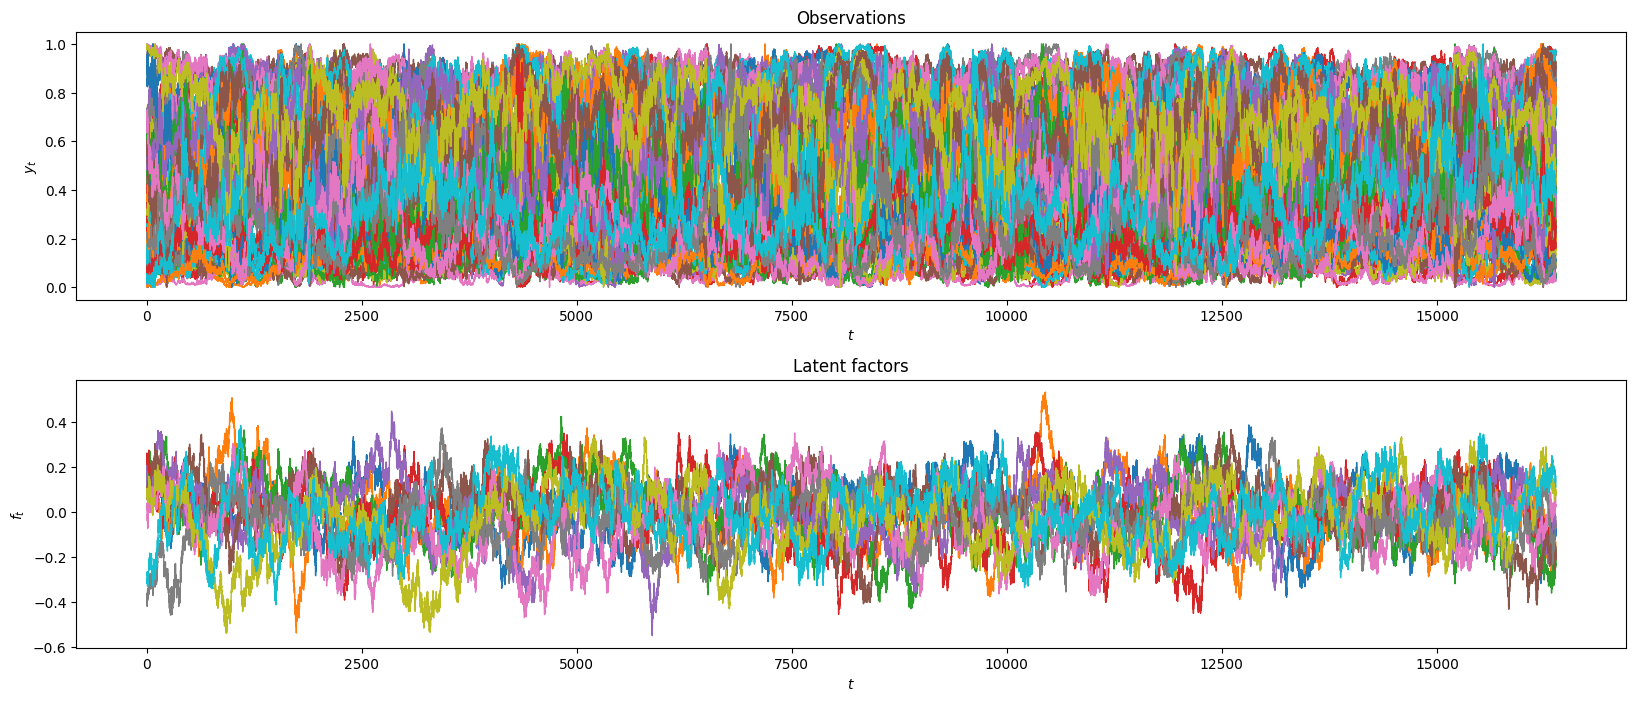

In [47]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim,5, 10,20,40,50,60,70,80,90, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True, use_xavier=True)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [14]:
##torch.save(dec, '../DGP/saved/dec_4.pt')
#np.save(arr=y, file='../DGP/saved/y_4.npy')
#np.save(arr=f, file='../DGP/saved/f_4.npy')

In [29]:
from tqdm import tqdm
import math
def benchmarkExpandingWindowForecastPCA(y_train,y_test, T_max = math.inf):
    y_train = np.copy(y_train)
    y_test= np.copy(y_test)

    T = min(y_test.shape[0], T_max)
    pred = []
    for t in tqdm(range(T)):
        mod = PCA(n_components=cfg.factor_dim)
        f_train_hat = mod.fit_transform(y_train)
        f_test_hat = mod.transform(y_test)

        factorModel = VAR(f_train_hat)
        res = factorModel.fit(maxlags=1, ic='aic')
        test_model = VAR(np.concatenate([f_train_hat, f_test_hat[[0]]]))
        f_test_pred = test_model.predict(res.params, lags=res.k_ar)[[-1]]
        y_test_pred = mod.inverse_transform(f_test_pred)
        pred.append(y_test_pred)
        
        y_train = np.concatenate([y_train, y_test[[0]]])
        y_test = y_test[1:]
        
    return pred


### PCA

cc on train data: 0.7820189416252006
cc on test data: 0.71033174409423
mse on test data: 0.005861515179276466
Factor R2 on test data: -1.5904699880092927
1-step ahead  FMSE on the test set: 0.006474265726575029


100%|██████████| 200/200 [00:15<00:00, 12.54it/s]


Expanding window msfe: 0.011835995572526289


ValueError: x and y can be no greater than 2D, but have shapes (200,) and (200, 1, 50)

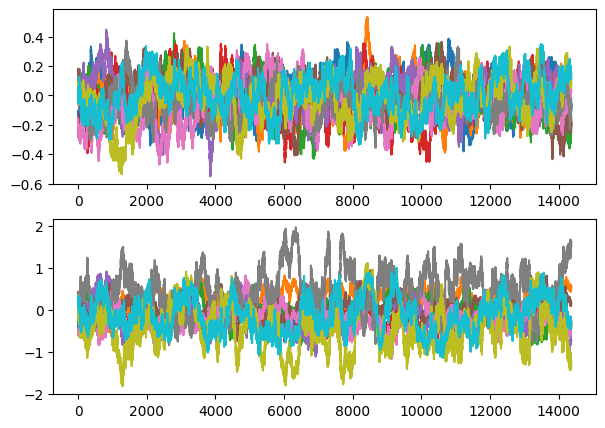

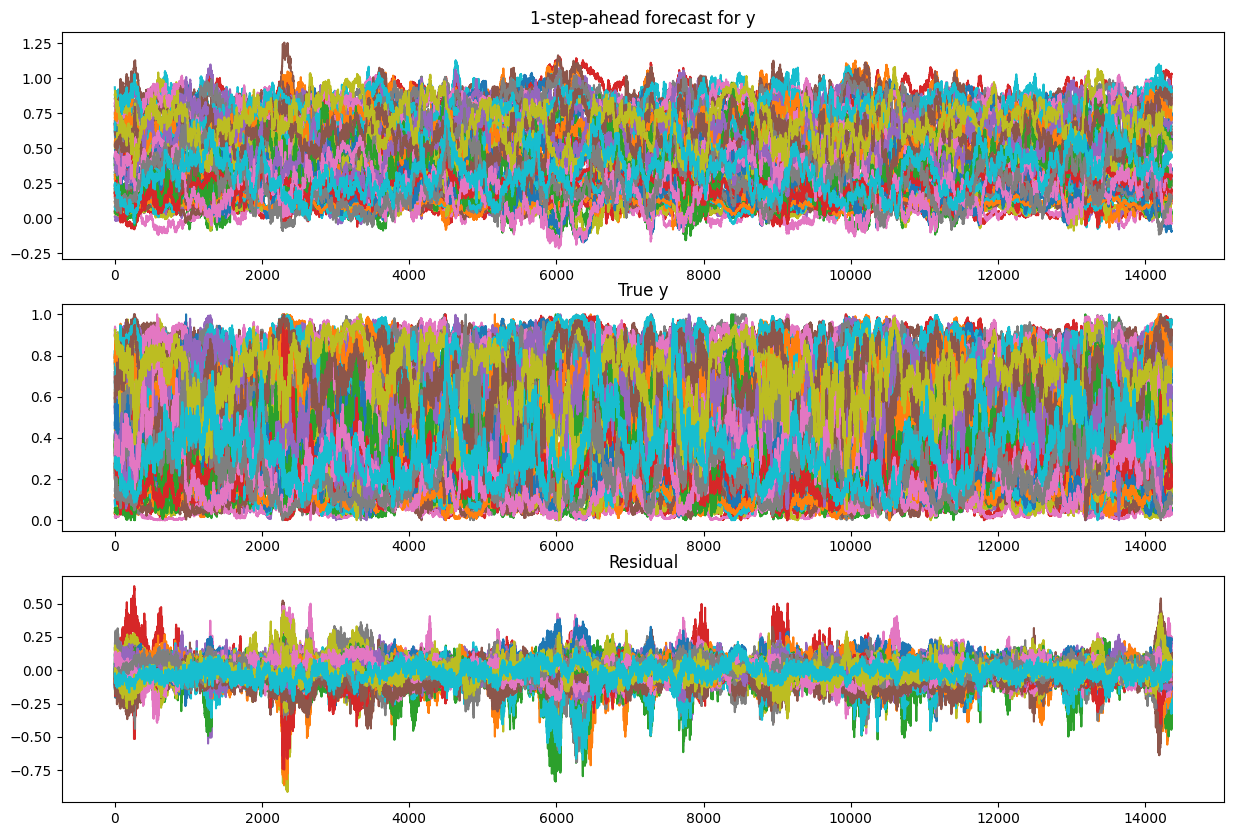

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_train_hat = pca.fit_transform(y_train)
#f_val_hat = pca.fit_transform(y_val)
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")

f_test_hat = pca.transform(y_test)
y_test_hat = pca.inverse_transform(f_test_hat)
mse = np.mean((y_test_hat-y_test)**2)
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")
print(f"mse on test data: {mse}")

cca = CCA(n_components=cfg.factor_dim, scale=False)
cca.fit(f_train_hat, f_train)
ccR2 = cca.score(f_train_hat, f_train)
print(f"Factor R2 on test data: {ccR2}")


fig,ax = plt.subplots(2,1, figsize=(7,5))
ax[0].plot(f_test);
ax[1].plot(cca.predict(f_test_hat));

f_val_hat = pca.transform(y_val)
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[cfg.T_train + cfg.T_val-2:]
y_test_pred = pca.inverse_transform(f_test_pred)

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")




y_test_pred = benchmarkExpandingWindowForecastPCA(np.concatenate([y_train,y_val]), y_test, T_max=200)
print(f'Expanding window msfe: {np.mean((y_test_pred - y_test[:100])**2)}')
plt.plot(y_test_pred)


In [59]:
mod = sm.tsa.DynamicFactor(endog=y_train, k_factors=cfg.factor_dim, factor_order=1, error_order=0)
#initial_res = mod.fit(method='powell', disp=True)
#res = mod.fit(initial_res.params, disp=True)
res = mod.fit( disp=True,maxiter=30)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          650     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90784D+02    |proj g|=  1.00143D+03


 This problem is unconstrained.



At iterate    1    f=  1.07573D+02    |proj g|=  7.35375D+01

At iterate    2    f=  9.29023D+01    |proj g|=  5.32431D+01

At iterate    3    f=  6.33350D+01    |proj g|=  2.31047D+01

At iterate    4    f=  4.60023D+01    |proj g|=  1.30644D+01

At iterate    5    f=  3.01257D+01    |proj g|=  1.43044D+01

At iterate    6    f=  2.36427D+01    |proj g|=  1.06669D+01

At iterate    7    f=  2.02878D+01    |proj g|=  1.33575D+01

At iterate    8    f=  1.90380D+01    |proj g|=  2.57824D+01

At iterate    9    f=  1.71306D+01    |proj g|=  6.22345D+01

At iterate   10    f=  1.68869D+01    |proj g|=  5.27614D+01

At iterate   11    f=  1.47217D+01    |proj g|=  3.61813D+01

At iterate   12    f=  1.41584D+01    |proj g|=  1.91685D+01

At iterate   13    f=  1.36534D+01    |proj g|=  2.70941D+01

At iterate   14    f=  1.33024D+01    |proj g|=  2.13757D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
testmod = sm.tsa.DynamicFactor(endog=y_test, k_factors=cfg.factor_dim, factor_order=1, error_order=0)
test = mod.filter(res.params)

cc on test data: 0.5882567050091265


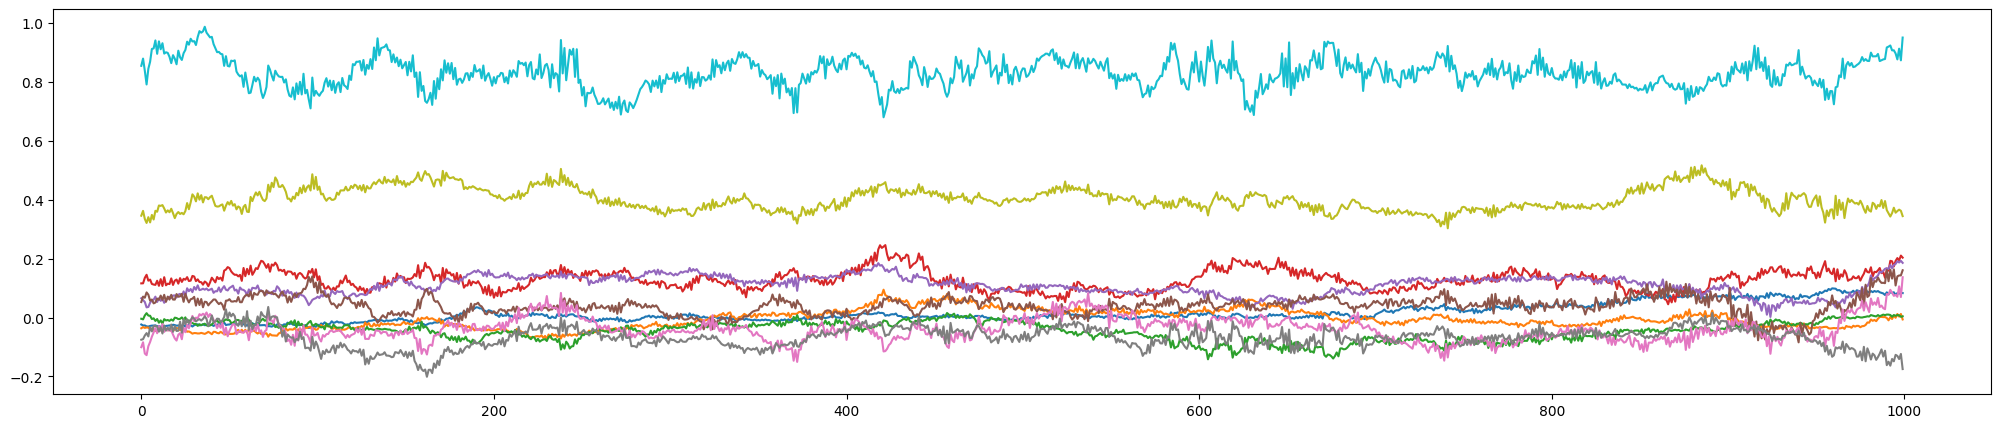

In [71]:
plt.plot(test.factors['filtered'].T);
cancorr = CanCorr(test.factors['filtered'].T, f_test[:1000])
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

In [58]:
mod = sm.tsa.DynamicFactorMQ(y_train, factors=cfg.factor_dim)
mod.summary()
mod.fit()

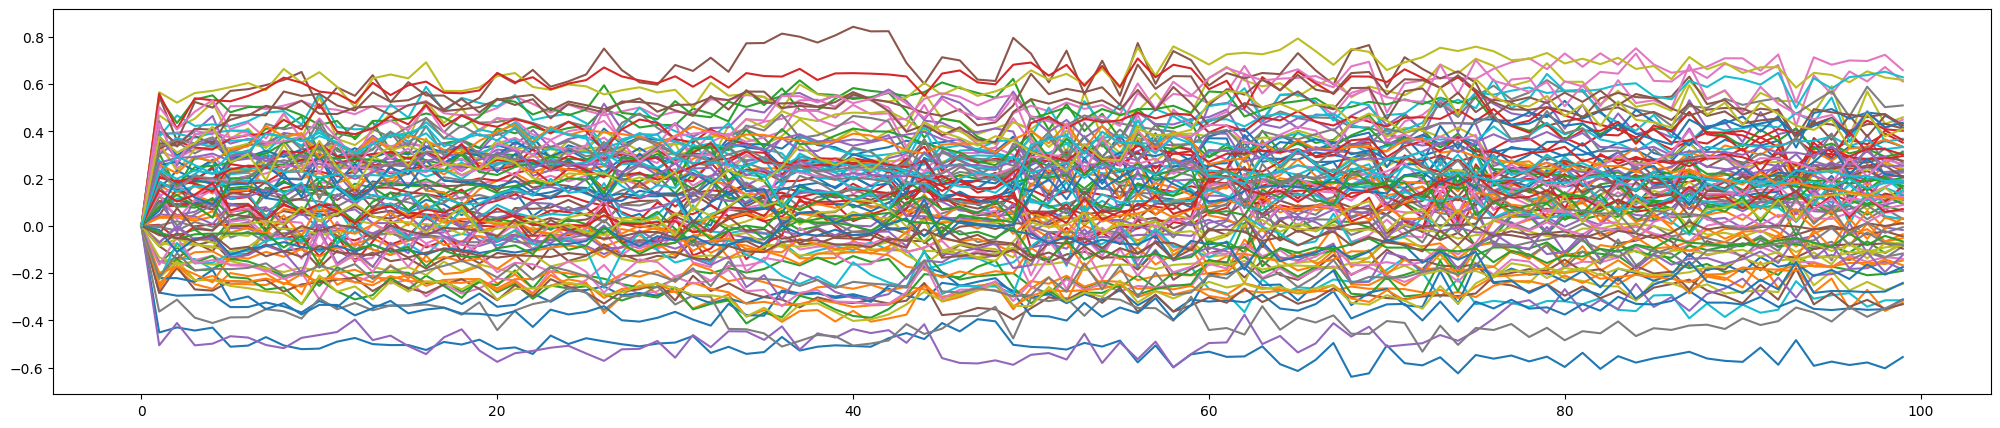

In [19]:
plt.plot(res.predict());

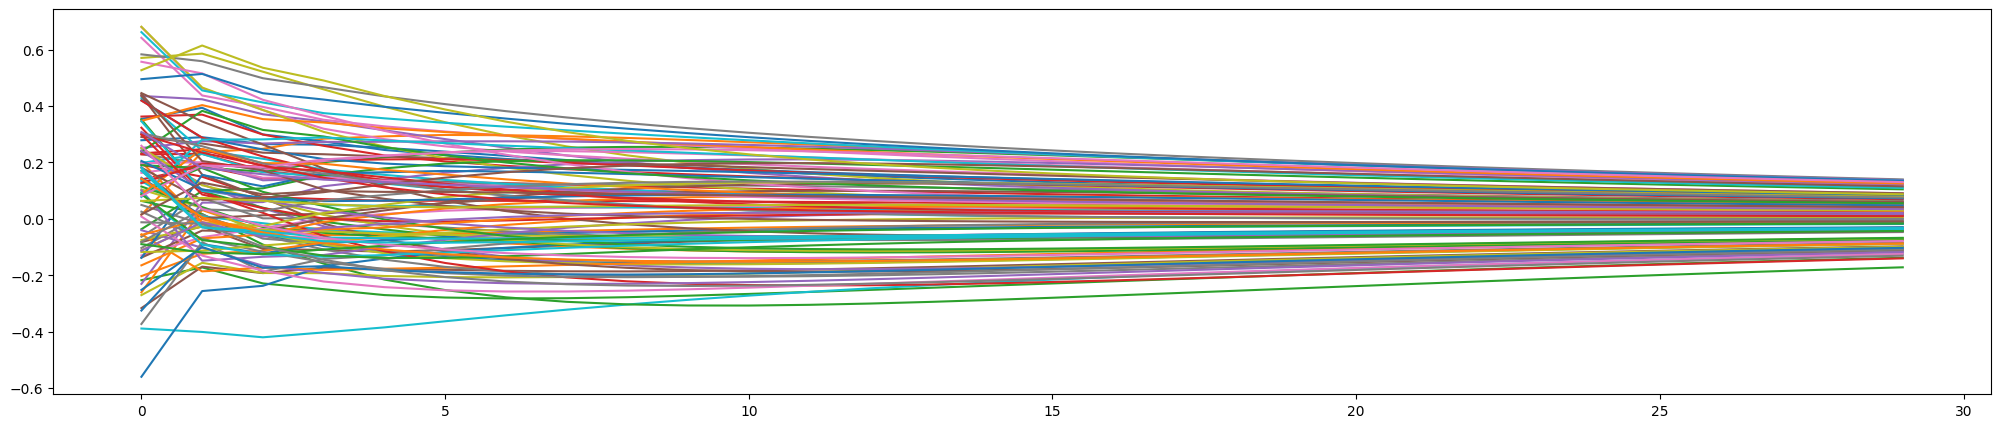

In [20]:
plt.plot(res.forecast(steps=30));